### 1. Example on Spatial Query with QGIS 

- provinces, cities and districts are polygons
- middle schools are points
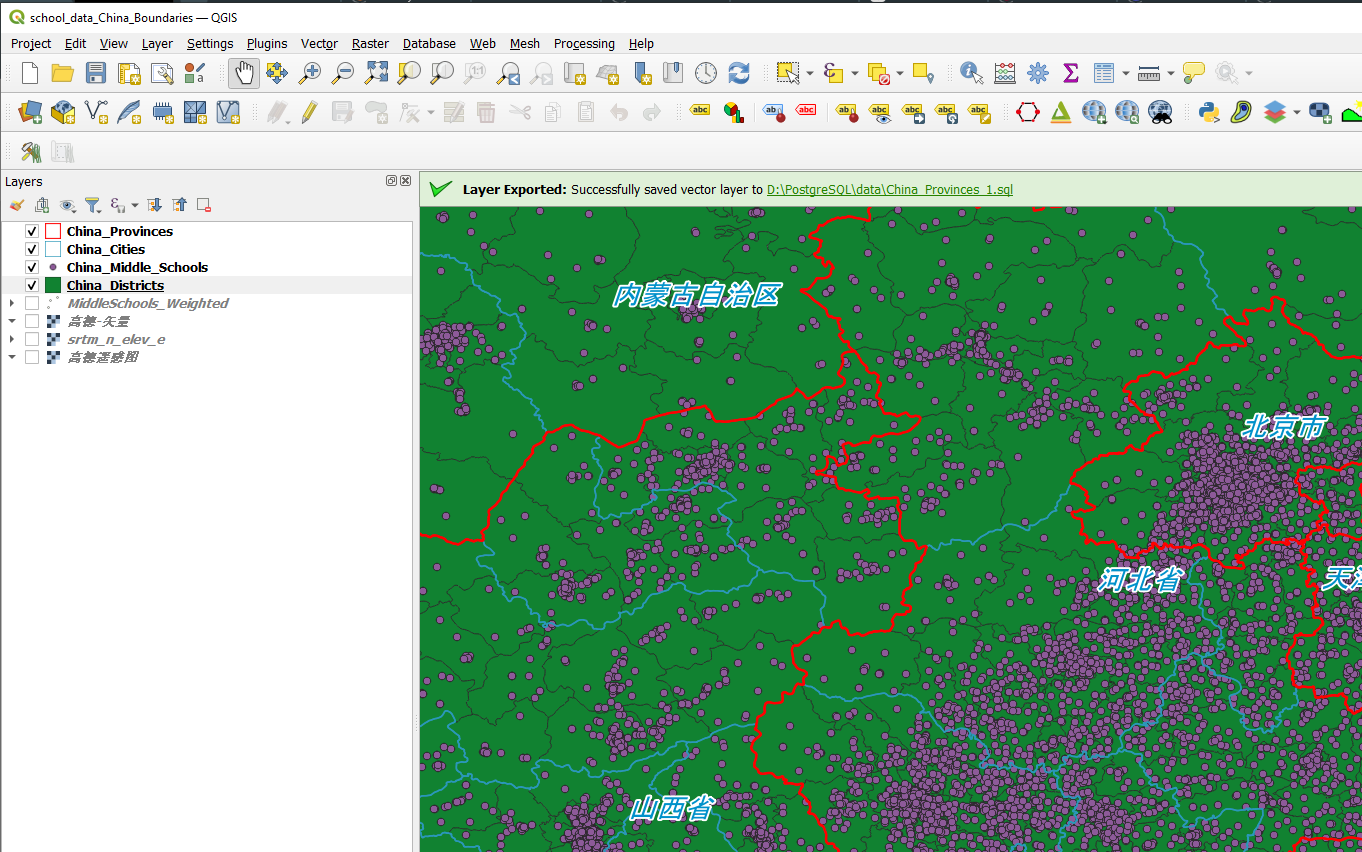

- 1. select a polygon in district layer (one polygon is one unique district)
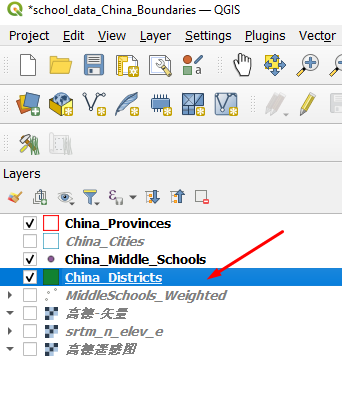
- 2. click select features 
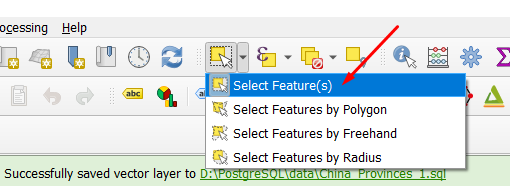
- 3. click the district you want to use, it will be highlighted with yellow color
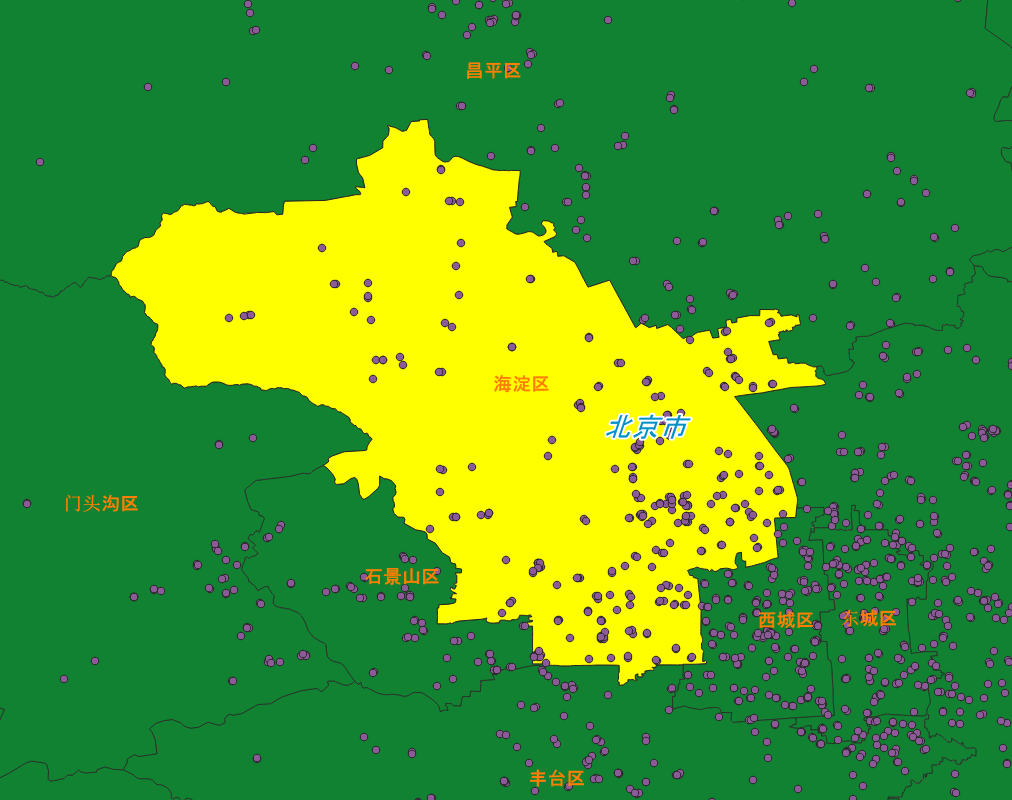

- 4. find the right query tool from toolbox. we will use "select by location" tool in "Vector selection"
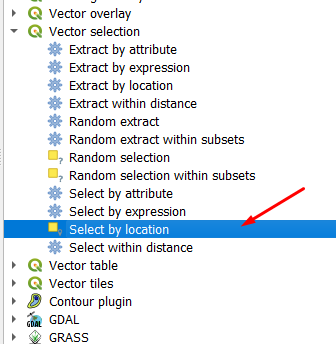

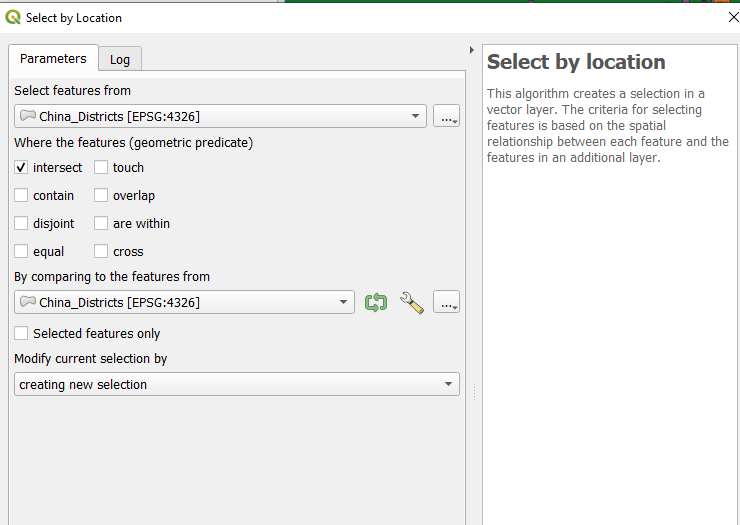

- 5. set "Select features from" to use middle schools point layer
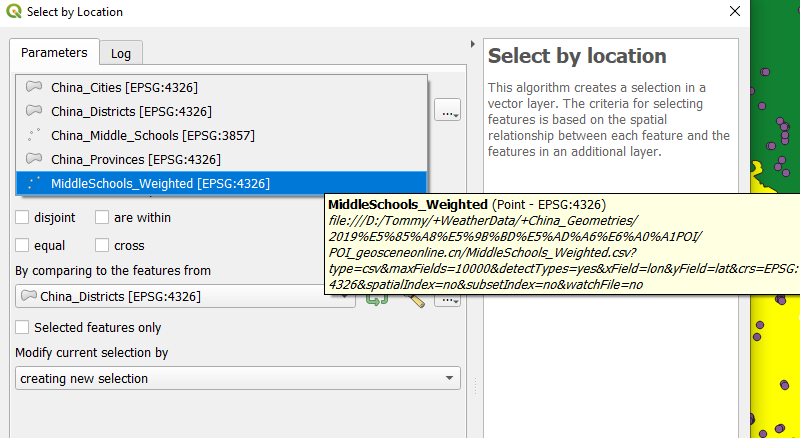

- 6. in where section, leave "intersect" and check "are within", we want to select all points in or on the edge of this district polygon. don't forget to check "selected feature only" so that only use the feature you selected to perform query
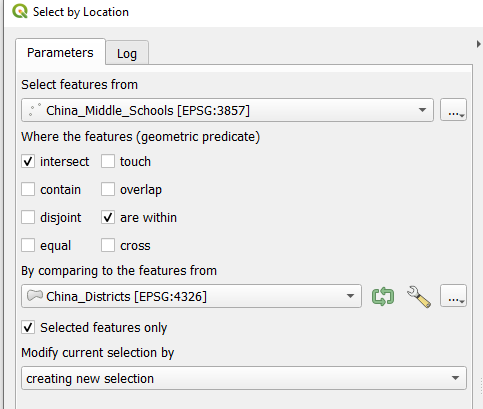

- 7. all schools in Haidian disctrict are selected, and changed to yellow points.
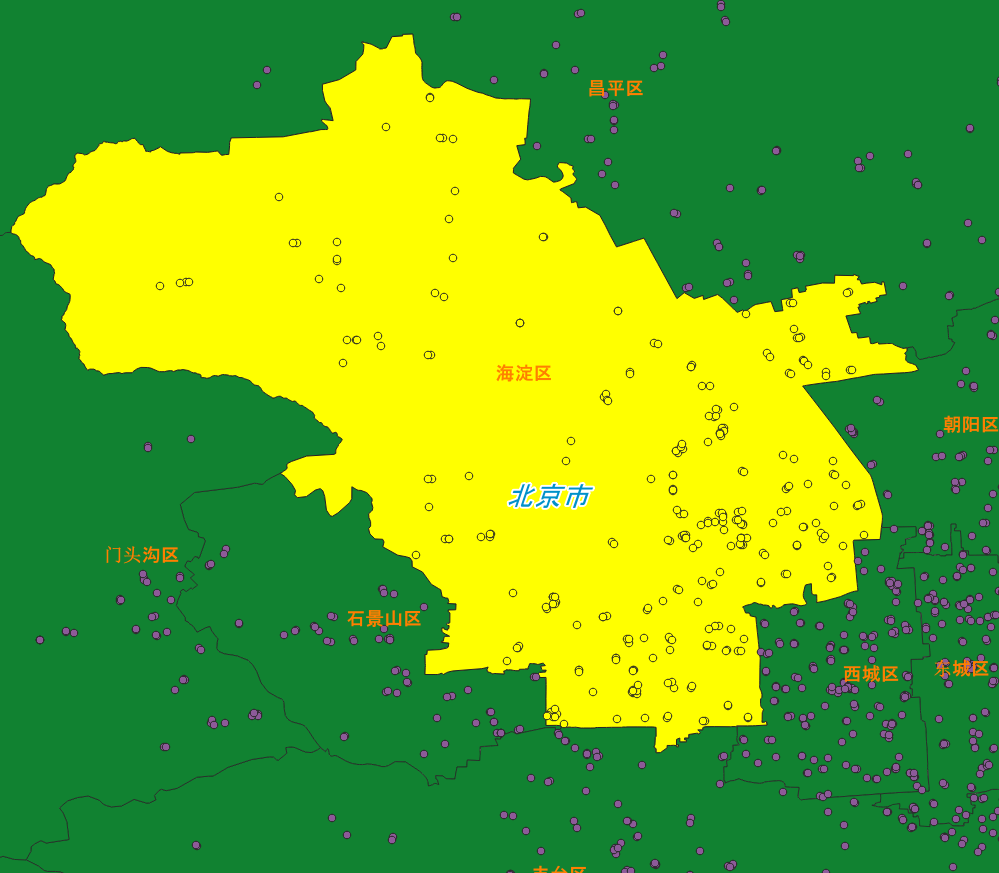

- 8. check the attributes of middle school, and by default, it will show all features
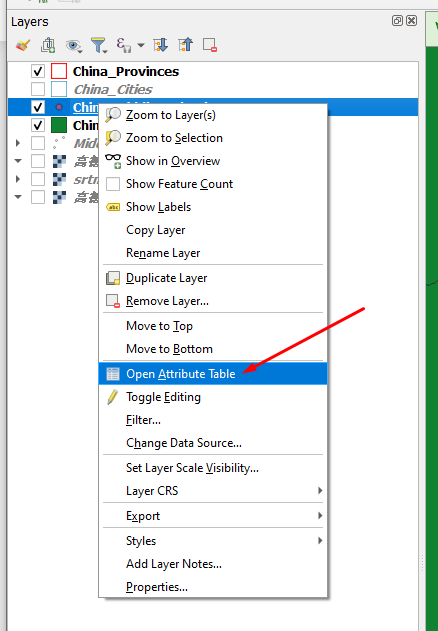
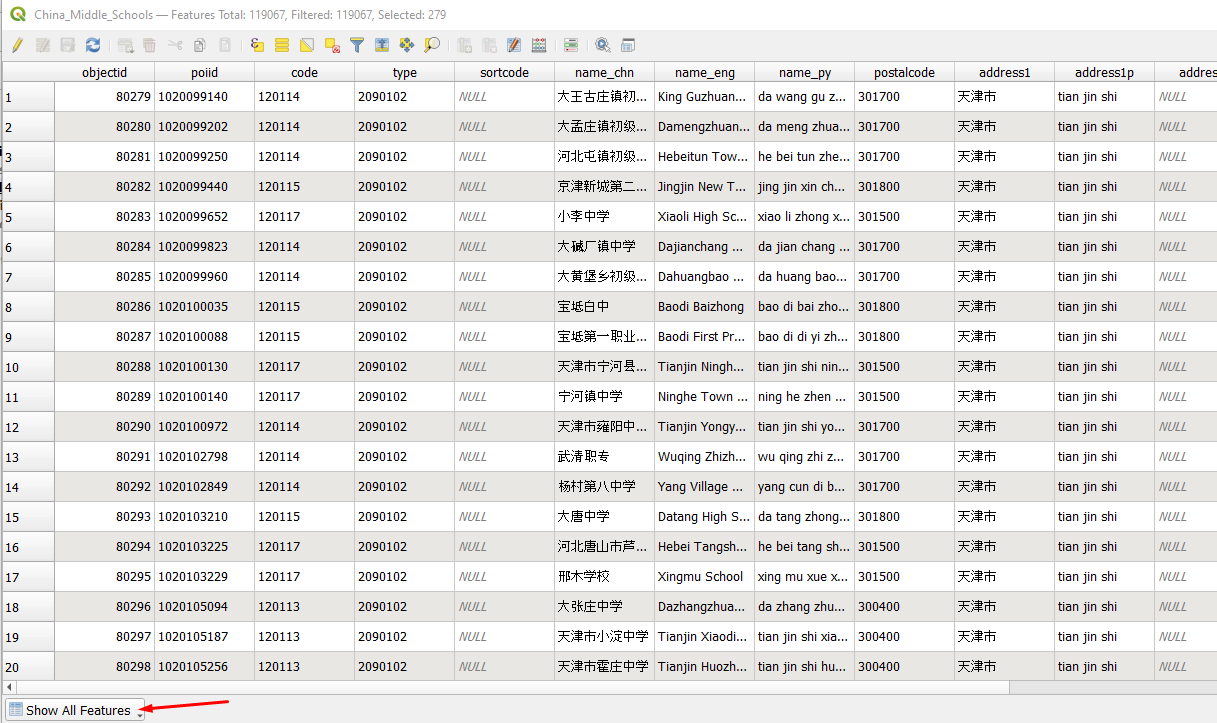

- 9. we select "Show Selected Features"
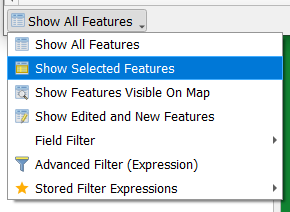

- 10. we can find out 279 schools are selected and they are all in Haidian district
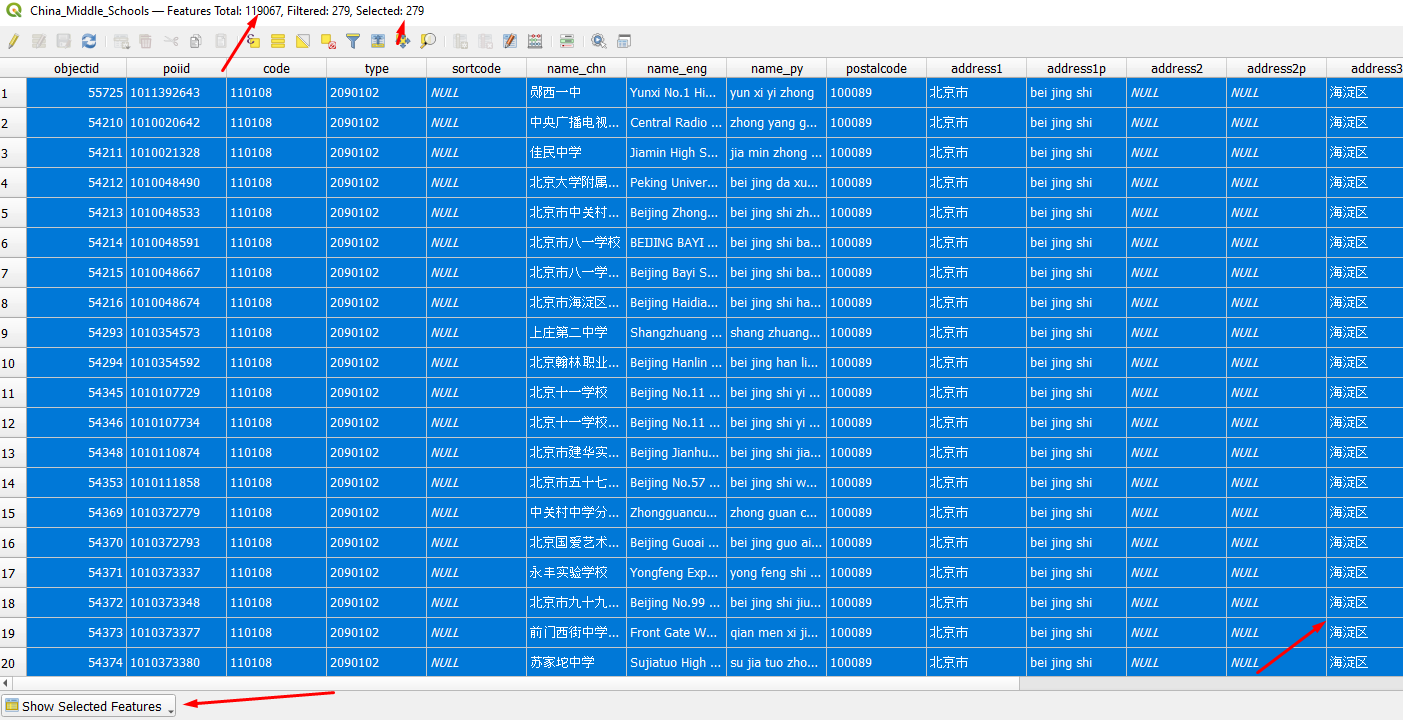

- 11. Remove selected features
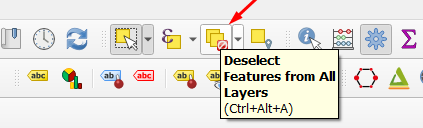

### If we want to warn schools in Haidian district, these 279 schools are targets. this how we use spatial query to find the targets we need



### 2. Spatial Query in Postgresql DB

```
SELECT p.name_chn	
FROM public."China_Middle_Schools" p
JOIN public."China_Districts" d ON ST_Contains(d.geom, p.geom)
WHERE d.dt_adcode = '110108';
```

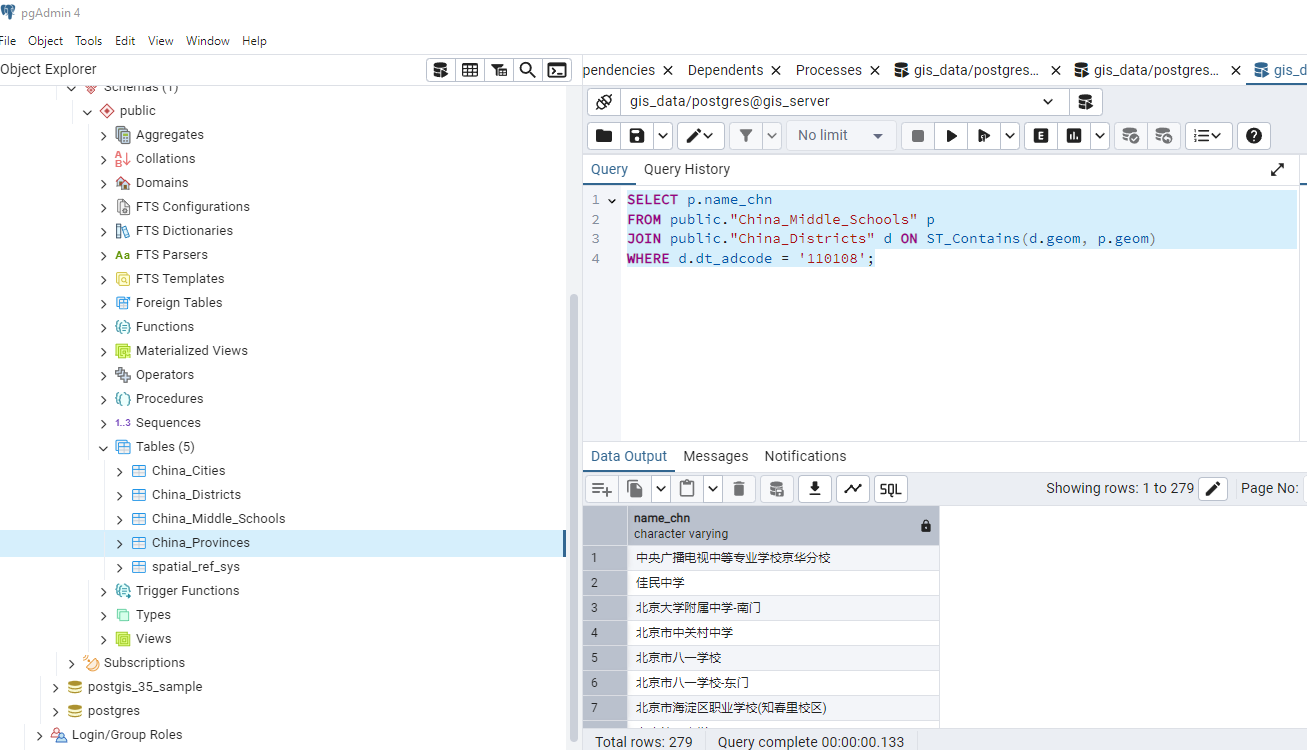

### 2.1 Multiple ways

#### Contains
```
SELECT p.name_chn	
FROM public."China_Middle_Schools" p
JOIN public."China_Districts" d ON ST_Contains(d.geom, p.geom)
WHERE d.dt_adcode = '110108';
```

#### Intersect
```
SELECT p.name_chn	
FROM public."China_Middle_Schools" p
JOIN public."China_Districts" d ON ST_Intersects(p.geom, d.geom)
WHERE d.dt_adcode = '110108';
```

### 3. Load Geojson data from file

- in the future, geojson file will represent the weather realted polygon
- this will be convert to WKT string
- query the schools with this polygon in postgresql

In [21]:
import geojson
from shapely.geometry import shape
from flask import Flask, request, jsonify
import psycopg2
from shapely import wkt

In [18]:
geojson_file = r"D:\PostgreSQL\data\Beijing_Haidian_District.geojson"
f = open(geojson_file,"r", encoding="utf-8")
data = geojson.load(f)

In [22]:
# Assuming the GeoJSON contains a single Polygon feature
if data['type'] == 'Feature' and data['geometry']['type'] == 'Polygon':
    print('single')
    polygon = shapely.geometry.shape(data['geometry'])
    print(polygon)

# If the GeoJSON contains multiple features or other geometry types, you'll need to iterate and handle each accordingly
else:
    print('collections')
    for feature in data['features']:
        #print(feature)
        if feature['geometry']['type'] == 'Polygon' or feature['geometry']['type'] == 'MultiPolygon':
            polygon = shapely.geometry.shape(feature['geometry'])
            #print(polygon)
            wkt_polygon = shape(polygon).wkt
            print('=========================================')
            print( wkt_polygon)

collections
MULTIPOLYGON (((116.259179 39.896582, 116.25867 39.896539, 116.25867 39.896995, 116.259451 39.897015, 116.259716 39.897256, 116.256972 39.897264, 116.256976 39.897152, 116.256765 39.897153, 116.256761 39.89726, 116.252994 39.89722, 116.252994 39.897289, 116.252981 39.898888, 116.252985 39.900082, 116.252988 39.900104, 116.252986 39.900244, 116.253043 39.900253, 116.253012 39.900616, 116.252987 39.900641, 116.252997 39.903714, 116.253016 39.903855, 116.253017 39.903889, 116.252998 39.904023, 116.252999 39.904496, 116.252974 39.907439, 116.253009 39.910017, 116.253035 39.912886, 116.252984 39.915551, 116.252906 39.915549, 116.252653 39.915543, 116.249739 39.915469, 116.249513 39.915552, 116.249435 39.915691, 116.249296 39.916086, 116.249253 39.916268, 116.249296 39.91645, 116.249505 39.916711, 116.249686 39.916889, 116.250007 39.916882, 116.250428 39.917399, 116.250423 39.917579, 116.252209 39.917568, 116.252771 39.917559, 116.253006 39.917686, 116.253058 39.918332, 116.25172

In [23]:
# Connect to your PostGIS database
conn = psycopg2.connect(
    dbname="gis_data", user="postgres", password="accu@385", host="localhost"
)

In [26]:
query = """
    SELECT name_chn FROM public."China_Middle_Schools" 
    WHERE ST_Contains(ST_GeomFromText(%s, 4326), geom);
    """
with conn.cursor() as cur:
        cur.execute(query, (wkt_polygon,))
        results = cur.fetchall()
print(len(results))

279


In [28]:
for row in results:
    print(row[0])

中央广播电视中等专业学校京华分校
佳民中学
北京大学附属中学-南门
北京市中关村中学
北京市八一学校
北京市八一学校-东门
北京市海淀区职业学校(知春里校区)
上庄第二中学
北京翰林职业学校
北京十一学校
北京十一学校-西门
北京市建华实验学校-南2门
北京市五十七中学
中关村中学分校(环谷园路)
北京国爱艺术学校
永丰实验学校
北京市九十九中学
前门西街中学分校
苏家坨中学
北京市温泉第二中学
人大附中北大附小联合实验学校
海淀北部新区实验中学
北京唐人美食学校
北京新海淀计算机学校
北京东方汽车维修学校
北京二十中学(新都校区)-东门
北京市海淀区红星子弟学校
北京市清河中学
北京市育英中学
北京市育英中学-东门
北京育英学校
北京十一学校(一分校)
北京市玉渊潭中学
北京市永定路中学
北京市太平路中学
人大附中翠微学校
北京市海淀外国语实验学校-东门
北京市海淀实验中学
首师大二附中
北京市海淀外国语实验学校-外语教研大楼
北京市海淀区艺术职业学校(明光路)
北方交通大学附属中学
北方交通大学附属中学-南门
北京市外国语大学附属中学
中国人民大学附属中学-东门
北京市八一学校-西门
中关村中学分校
北京师范大学第三附属中学
北京市一零一实验学校
北京一零一中双榆树校区
北京市六一中学
首都师范大学第二附属中学(花园村校区)
北京市幼儿师范学校
北京市经济管理学校
北京市海淀区东升学区
北京市残疾人职业高中
育华学校
北方交通大学附属中学分校
中国人民大学附属中学(第二分校)
北京市第十九中学(中校区)
北京市北达资源中学-南门
北京市北达资源中学
北京一零一中学-南门
北京市商务管理学校(西苑校区)
中国矿业大学学院路校区(北京)附属中学
中关村中学(清华园校区)
北京科技大学附属中学-北门
石油学院附中
北京市熊希龄实验学校
北京市海淀实验中学(阜成路北二街)
北京理工大附中分校
北京市海淀区职业学校
中国地质大学附属中学
北航附中
首都师大附中(西校区)(阜石路)
北京市海淀区尚丽外国语学校
北京市师达中学
清华育才实验学校
北京市海淀外国语实验学校-才艺中心
北京市海淀外国语实验学校-留学中心
北京市海淀外国语实验学校-学前教育中心
北京大学附属中学-西门
北京交通大学附属中学(南校区)
北京交通大学附属中学(第二分校)
北京市八一中学(北校区)
海淀区

### 4. Automatic with Python

In [2]:
from flask import Flask, request, jsonify
import psycopg2
from shapely import wkt

app = Flask(__name__)

# Connect to your PostGIS database
conn = psycopg2.connect(
    dbname="your_db", user="your_user", password="your_password", host="localhost"
)

@app.route('/query', methods=['POST'])
def query_pois():
    data = request.json
    polygon = data['polygon']  # Expecting GeoJSON or WKT polygon string
    
    # Convert GeoJSON to WKT if necessary
    if 'type' in polygon:  # GeoJSON input
        from shapely.geometry import shape
        wkt_polygon = shape(polygon).wkt
    else:
        wkt_polygon = polygon  # Assume WKT string
    
    query = """
    SELECT name FROM poi
    WHERE ST_Contains(ST_GeomFromText(%s, 4326), geom);
    """
    with conn.cursor() as cur:
        cur.execute(query, (wkt_polygon,))
        results = cur.fetchall()
    
    return jsonify([row[0] for row in results])

if __name__ == '__main__':
    app.run(debug=True)
